# Model performance on Test dataset

In [1]:
from tensorflow import keras
import cv2
import matplotlib.image as img
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from libs.preprocessing import ImageToArrayPreprocessor
from libs.preprocessing import SimplePreprocessor
from libs.datasets import SimpleDatasetLoader
import pandas as pd
from libs.utils.myplot import plot_confusion_matrix
import os

2023-02-17 21:06:13.395773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 21:06:13.835772: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/viv/miniconda3/lib/
2023-02-17 21:06:13.835813: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/viv/miniconda3/lib/
2023-02-17 21:06:13.835819: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [2]:
SAVED_MODEL_PATH = 'model/ge_traffic_sign_recognition.h5'
DATASET_DIR = './gtsrb-german-traffic-sign'
TEST_CSV = f'{DATASET_DIR}/Test.csv'
BATCH_SIZE = 32
IMG_WIDTH = IMG_HEIGHT = 32
RANDOM_STATE=42

In [3]:
classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'}

## Prepare the Testing Dataset

In [4]:
test_dataset_df = pd.read_csv(TEST_CSV)
test_dataset_df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [5]:
# add full path to Path column
test_dataset_df.Path = test_dataset_df.Path.apply(lambda img_path: os.path.join(DATASET_DIR, img_path))

In [6]:
test_dataset_df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,./gtsrb-german-traffic-sign/Test/00000.png
1,42,45,5,5,36,40,1,./gtsrb-german-traffic-sign/Test/00001.png
2,48,52,6,6,43,47,38,./gtsrb-german-traffic-sign/Test/00002.png
3,27,29,5,5,22,24,33,./gtsrb-german-traffic-sign/Test/00003.png
4,60,57,5,5,55,52,11,./gtsrb-german-traffic-sign/Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,./gtsrb-german-traffic-sign/Test/12625.png
12626,50,51,6,5,45,46,33,./gtsrb-german-traffic-sign/Test/12626.png
12627,29,29,6,6,24,24,6,./gtsrb-german-traffic-sign/Test/12627.png
12628,48,49,5,6,43,44,7,./gtsrb-german-traffic-sign/Test/12628.png


## Dispaly Testing Images

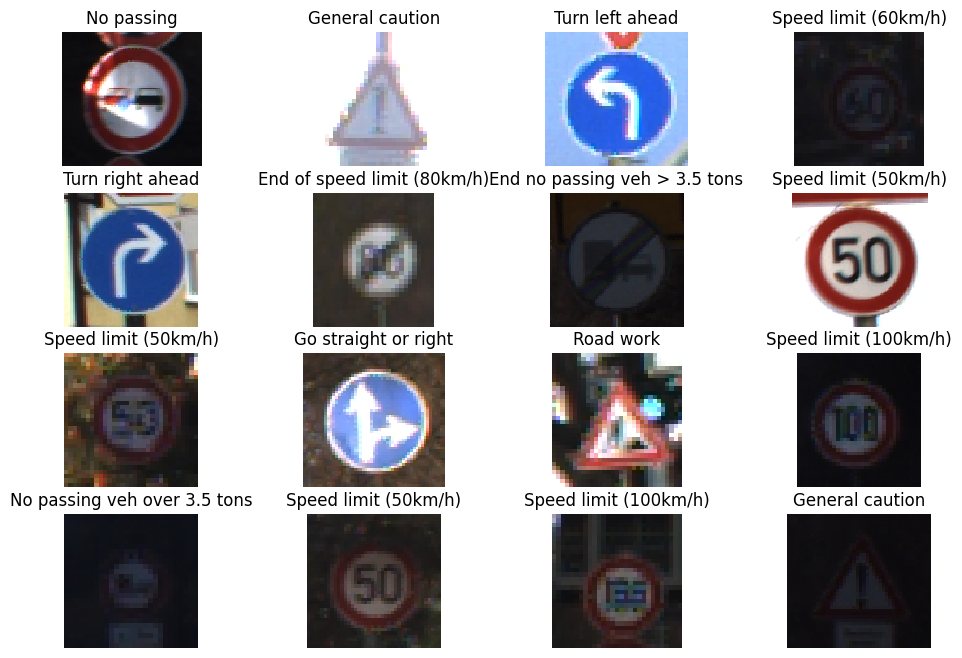

In [7]:
random_num_array = np.random.randint(len(test_dataset_df.Path), size=16)
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))

for ax, num in zip(axs.ravel(), random_num_array):
    _img = img.imread(test_dataset_df.Path[num])
    class_id = test_dataset_df.ClassId[num]
    ax.set_title(f'{classes[class_id]}')
    ax.imshow(_img, interpolation='none')
    ax.axis("off")
# plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

## Loading and Preprocessing Dataset

In [8]:
# initialize the image preprocessor
sp = SimplePreprocessor(IMG_WIDTH, IMG_HEIGHT, inter=None)
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])

In [9]:
X_test, Y_test = sdl.load(class_id=test_dataset_df.ClassId,paths= test_dataset_df.Path, verbose=500)

[INFO] processed 500/12630
[INFO] processed 1000/12630
[INFO] processed 1500/12630
[INFO] processed 2000/12630
[INFO] processed 2500/12630
[INFO] processed 3000/12630
[INFO] processed 3500/12630
[INFO] processed 4000/12630
[INFO] processed 4500/12630
[INFO] processed 5000/12630
[INFO] processed 5500/12630
[INFO] processed 6000/12630
[INFO] processed 6500/12630
[INFO] processed 7000/12630
[INFO] processed 7500/12630
[INFO] processed 8000/12630
[INFO] processed 8500/12630
[INFO] processed 9000/12630
[INFO] processed 9500/12630
[INFO] processed 10000/12630
[INFO] processed 10500/12630
[INFO] processed 11000/12630
[INFO] processed 11500/12630
[INFO] processed 12000/12630
[INFO] processed 12500/12630


Normalization 

When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). 
https://www.tensorflow.org/tutorials/images/data_augmentation

In [10]:
# X_test= X_test.astype("float") / 255.0
# np.min(X_test), np.max(X_test)

## Loading the saved model

In [11]:

model = keras.models.load_model(SAVED_MODEL_PATH)

2023-02-17 21:06:16.838057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 21:06:16.858247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 21:06:16.858468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-17 21:06:16.858917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [12]:
preds = model.predict(X_test, batch_size=BATCH_SIZE)
preds[:10]

2023-02-17 21:06:17.955960: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600


130/395 [========>.....................] - ETA: 0s

2023-02-17 21:06:18.328927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


395/395 [==============================] - 1s 1ms/step


array([[1.19700641e-32, 0.00000000e+00, 1.62111743e-16, 5.31003465e-21,
        1.17530905e-27, 3.18623900e-28, 6.47925551e-32, 2.71933163e-21,
        1.00000000e+00, 2.05234793e-34, 1.09064372e-32, 1.87527583e-26,
        0.00000000e+00, 1.99419146e-23, 1.27050276e-33, 1.68738784e-38,
        5.07144039e-26, 1.65446973e-27, 1.69818982e-32, 2.80324017e-32,
        3.85579225e-27, 3.38888216e-24, 6.93275924e-27, 3.28644648e-17,
        1.53817187e-24, 4.17610583e-36, 4.87979927e-26, 1.25469123e-32,
        1.25293122e-32, 2.68586330e-31, 8.63695944e-32, 2.87595718e-29,
        0.00000000e+00, 6.53764995e-32, 0.00000000e+00, 1.31503945e-26,
        1.28662154e-19, 4.24908586e-17, 9.12017423e-12, 3.60533777e-26,
        2.89034175e-15, 6.79148079e-29, 6.27120805e-13],
       [7.11360345e-16, 1.00000000e+00, 7.36816316e-32, 4.35640385e-27,
        8.88627826e-32, 1.97678753e-37, 4.62996944e-31, 3.91986132e-34,
        1.67241933e-29, 8.52449996e-30, 4.07127030e-27, 1.18726941e-33,
       

In [13]:
preds = np.argmax(preds, axis=1)
preds[:10]

array([ 8,  1, 32, 27,  3, 32, 10,  4, 18, 29])

In [14]:
Y_test[:10]

array([16,  1, 38, 33, 11, 38, 18, 12, 25, 35])

In [15]:

print(classification_report(Y_test,
                            preds,
                            target_names=classes.values())
      )

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.87      0.68      0.77        60
         Speed limit (30km/h)       0.90      0.97      0.93       720
         Speed limit (50km/h)       0.00      0.00      0.00       750
         Speed limit (60km/h)       0.00      0.00      0.00       450
         Speed limit (70km/h)       0.00      0.00      0.00       660
         Speed limit (80km/h)       0.00      0.00      0.00       630
  End of speed limit (80km/h)       0.00      0.00      0.00       150
        Speed limit (100km/h)       0.00      0.00      0.00       450
        Speed limit (120km/h)       0.00      0.00      0.00       450
                   No passing       0.00      0.00      0.00       480
 No passing veh over 3.5 tons       0.00      0.00      0.00       660
 Right-of-way at intersection       0.00      0.00      0.00       420
                Priority road       0.00      0.00      0.00       690
     

## Testing